# Imports

In [73]:
#ALL OF THE IMPORTS AND SUCH

from LightPipes import *
import matplotlib.pyplot as plt
import matplotlib.colors
# import matplotlib.cm
import math
# import cmath
# from numpy import genfromtxt
import colorcet as cc
# import random
import aotools
# import itertools
from tqdm import tqdm as progress

import numpy as np
# from numpy.linalg import eig,eigh
import scipy as sp

# plt.style.use('dark_background')
plt.style.use('default')

# Colourmaps

In [74]:
#Generate Colormap Intensity
cmap = np.zeros([256, 4])
cmap[:, 3] = np.linspace(0, 1, 256)
cmap[:, 0]= np.linspace(0, 0, 256)
cmap[:, 1]= np.linspace(0, 0, 256)
cmap[:, 2]= np.linspace(0, 0, 256)
#Intensity colours
imap = matplotlib.colors.ListedColormap(cmap)
#Phase colours
pmap= cc.m_CET_C6

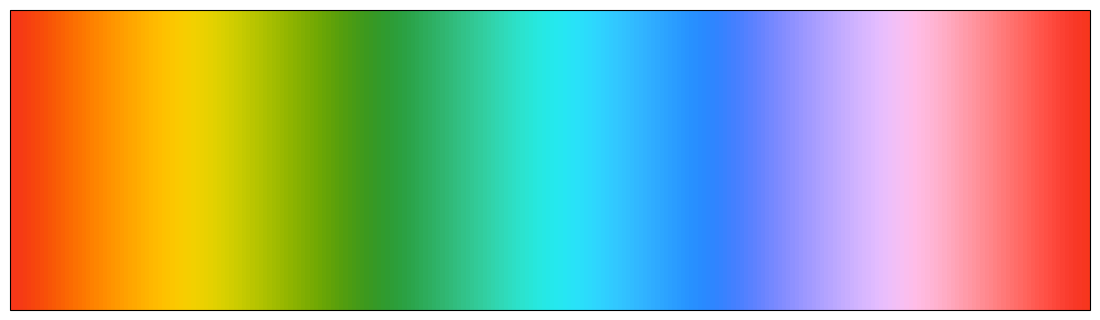

In [75]:
#Generate Phase colormap
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=pmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.1, 1.2, 2])
pl.colorbar(orientation="horizontal", cax=cax, ticks=[])
# pl.savefig("colorbar.png")

# Functions

### Generate Beams

In [76]:
#These are some functions for making beams in the OAM Basis

#OAM beams 
def OAM(state: int=0 ,phase=0,amp=1):
    F=Begin(size,wavelength,N)
    F=GaussLaguerre(F, w0, p=0, l=state, A=amp*(1/w0)*np.sqrt(2/(np.pi*(math.factorial(abs(state))))), ecs=0)
    F=SubPhase(F,Phase(F)+phase)
    return F

### Propogate Beams

In [77]:
#Functions to propogate the beam through a channel

#Propagates one beam through the channel defined by the distance and the list of abberations that is input (abbs)
#If there are abberations, distance is the distance per abberation
def propChannel(F,distance,abbs=1,mode=0):
    if not hasattr(abbs, "__len__"):
        for i in range(abbs):
            if mode==1:
                F=Forvard(F,int(distance/abbs))
            elif mode == 2:
                F=Forward(F,int(distance/abbs),size,N)
            else:
                F=Fresnel(F,int(distance/abbs))

    else:
        for screen in abbs:
            F=SubPhase(F,Phase(F)+screen)
            if mode==1:
                F=Forvard(F,int(distance/len(abbs)))
            elif mode == 2:
                F=Forward(F,int(distance/len(abbs)),size,N)
            else:
                F=Fresnel(F,int(distance/len(abbs)))
    return F

### Plot Beams

In [78]:
##These are custom functions for plotting the beams.

def plotBeam(F):
    if not hasattr(F, "__len__"):
        plotbeamsingle(F)
    else:
        plotbeammulti(F)
        
#Show a plot of the beam with phase and intensity
def plotbeamsingle(F):
    I=1-Intensity(1,F)
    Phi=np.mod(Phase(F),2*np.pi)

    ##aperature = plt.Circle((N/2-1, N/2), 30*cm*N/(2*size), color='w', fill=False)
    fig=plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(121)
    ax1.imshow(Phi,cmap=pmap,vmin=0,vmax=2*pi,interpolation='None')
    ax1.imshow(I,cmap=imap,vmin=np.min(I),vmax=np.max(I),interpolation='None')
    ##ax1.add_patch(aperature)
        
    plt.axis('off')
    plt.tight_layout()

#Show a plot of the beams with phase and intensity
def plotbeammulti(Fs):
    fig = plt.figure(1)
    Tot = len(Fs)
    Cols = len(Fs)
    Rows = 1 
    Position = range(1,Tot + 1)
    for index,F in enumerate(Fs):
        I=1-Intensity(1,F)
        Phi=np.mod(Phase(F),2*np.pi)

        ##aperature = plt.Circle((N/2-1, N/2), 30*cm*N/(2*size), color='w', fill=False)
        ax = fig.add_subplot(Rows,Cols,Position[index])
        ax.imshow(Phi,cmap=pmap,vmin=0,vmax=2*np.pi,interpolation='None')
        ax.imshow(I,cmap=imap,vmin=np.min(I),vmax=np.max(I),interpolation='None')
        ##ax1.add_patch(aperature)
            
        plt.axis('off')
        plt.tight_layout()
    plt.show()

### Crosstalk

In [100]:
#These are custom functions to calculate the overlap integral between two modes

# This is the overlap integral to check the fidelity between two modes
def overlapInt(F,G):
    F,G=Normal(F),Normal(G)
    Ffield,Gfield=np.conjugate(F.field),G.field
    fieldArr=np.multiply(Ffield,Gfield)
    summed=abs(np.sum(fieldArr))**2
    return summed

#Normalizes the overlap integrals for a tomographic measurement in dimension d. 
def normTomography(ints, d):
    return np.concatenate([
        chunk / chunk.sum() if chunk.sum() != 0 else chunk
        for chunk in np.split(ints, range(d, len(ints), d))
    ])

#Crosstalk of two vectors
def crosstalkVecs(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(abs(np.dot(np.conjugate(F),G))**2)
        C.append(c/sum(c))
    return C

#Calculate full crosstalk of two beam lists
def crosstalk(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(c/sum(c))
    return C

def tomography(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(normTomography(c,math.isqrt(len(Fs))))
    return C

def plotCrosstalk(cross):
    fig, ax = plt.subplots()
    im = ax.imshow(cross, interpolation='none', cmap='viridis', vmin=0,vmax=1)
    ax.set_xlabel(r"$\ell_1$", fontsize=12)
    ax.set_ylabel(r"$\ell_2$", fontsize=12)
    cbar = plt.colorbar(im, ax=ax, aspect=10)
    cbar.set_label("Crosstalk Coupling Coefficient", fontsize=12, labelpad=15)
    plt.show()
    return fig
    

# Defining Beam and Phase Screen Parameters

In [116]:
pi = sp.constants.pi # pi
c = sp.constants.speed_of_light # speed of light

wavelength = 633*nm # beam wavelength
size = 30*cm # size of window generated
w0 = 3*cm # beam waist (radius)

z = 5400 # propagation distance (metres)
N = 256 # resolution

n = 5 # number of phase screens

# C^2_n parameter. dependent on strength of turbulence
C2_n = {
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}

# Set turbulence strength
turb_strength = 'MidTurb'

# Determine Fried parameter
# r0_i = pow(0.423*pow(2*pi/wavelength,2)*C2_n[turb_strength]*z,-3/5)
r0_i = pow(0.423*pow(2*pi/wavelength,2)*C2_n[turb_strength]*z/n,-3/5)

# Generate the phase screens
abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0_i,N,size/N,100,0.001) for i in range(n)]
print(len(abbs))

5


# Creating Beam and Propagating

100%|██████████| 5/5 [00:00<00:00, 98.60it/s]


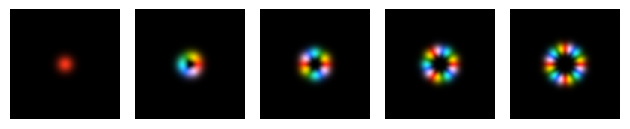

In [81]:
# just some dumb tests

# plotting some oam stuff
initBeams = [OAM(i) for i in progress(range(0,5))]

plotBeam(initBeams)

100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


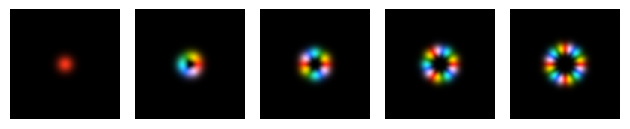

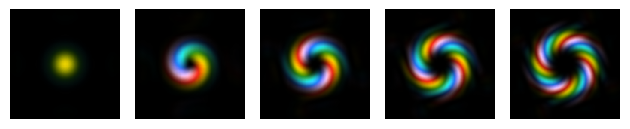

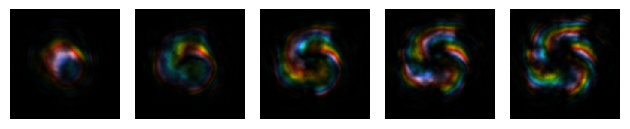

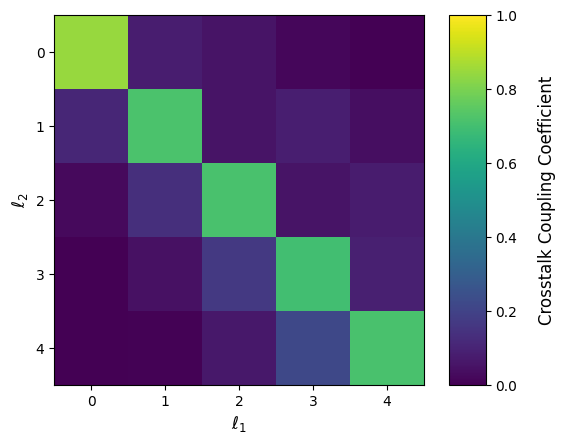

In [117]:
# First just get initial beams with no propagation
initBeams = [OAM(i) for i in progress(range(5))]

# Mode 0 - Fresnel - Has the 'Square' Effect at longer distances
beams=[propChannel(OAM(i),z,len(abbs),0) for i in progress(range(5))]
errorBeams=[propChannel(OAM(i),z,abbs,0) for i in progress(range(5))]

# Mode 1 - Forvard - Has drawbacks since walls act like waveguides - also stays centered with turbulence
# beams=[propChannel(OAM(i),z,len(abbs),1) for i in progress(range(5))]
# errorBeams=[propChannel(OAM(i),z,abbs,1) for i in progress(range(5))]

# Mode 2 - Forward - Takes way too long for serious res
# beams=[propChannel(OAM(i),z,len(abbs),2) for i in progress(range(5))]
# errorBeams=[propChannel(OAM(i),z,abbs,2) for i in progress(range(5))]

plotBeam(initBeams)
plotBeam(beams)
plotBeam(errorBeams)

# fig = plotCrosstalk(crosstalk(initBeams,initBeams))
# fig.savefig('Crosstalk_LG.svg', format='svg', bbox_inches='tight')
fig = plotCrosstalk(crosstalk(beams,errorBeams))
# fig.savefig('Crosstalk_LG_StrongerTurb.svg', format='svg', bbox_inches='tight')